>> 폰트 설정이 적용되었습니다. 분석을 시작합니다.

### 1. 데이터 로드 및 전처리 ###
>> 데이터 처리 완료.

### 2. 모델 훈련 및 성능 평가 ###

최적 하이퍼파라미터: {'clf__C': np.float64(1.0), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}

--- 분류 리포트 (테스트 세트) ---
              precision    recall  f1-score   support

          -1      0.862     0.822     0.842       236
           0      0.387     0.511     0.440        94
           1      0.906     0.840     0.872       263

    accuracy                          0.781       593
   macro avg      0.718     0.724     0.718       593
weighted avg      0.806     0.781     0.791       593


### 3. 모델 진단 및 요인 분석 ###

--- 규제 강도(C)에 따른 모델 성능 변화 (Penalty: l2) ---


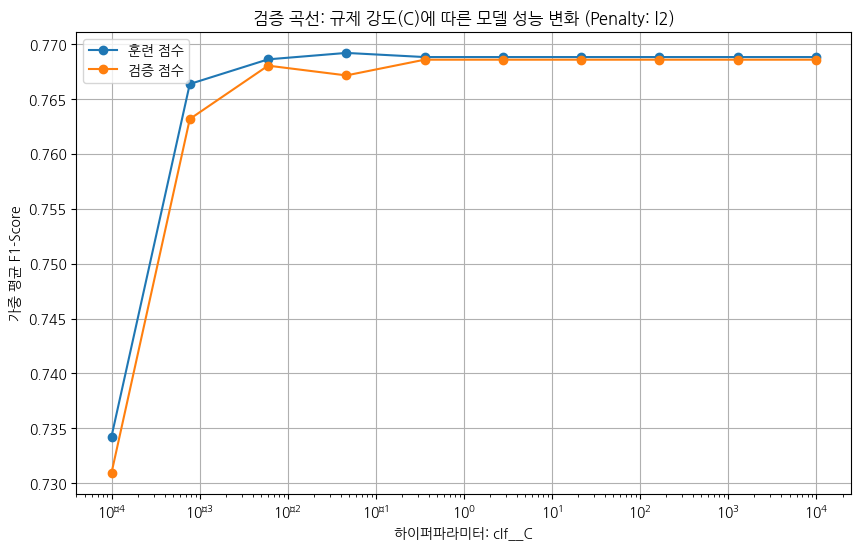

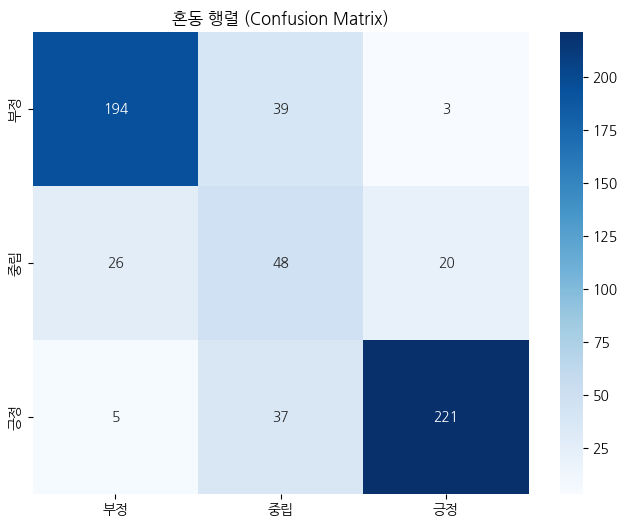


[순열 중요도 결과 (높을수록 중요)]
정시성     0.169309
환승편의    0.165936
쾌적성     0.092411
혼잡도     0.081956
소요시간    0.061046
dtype: float64


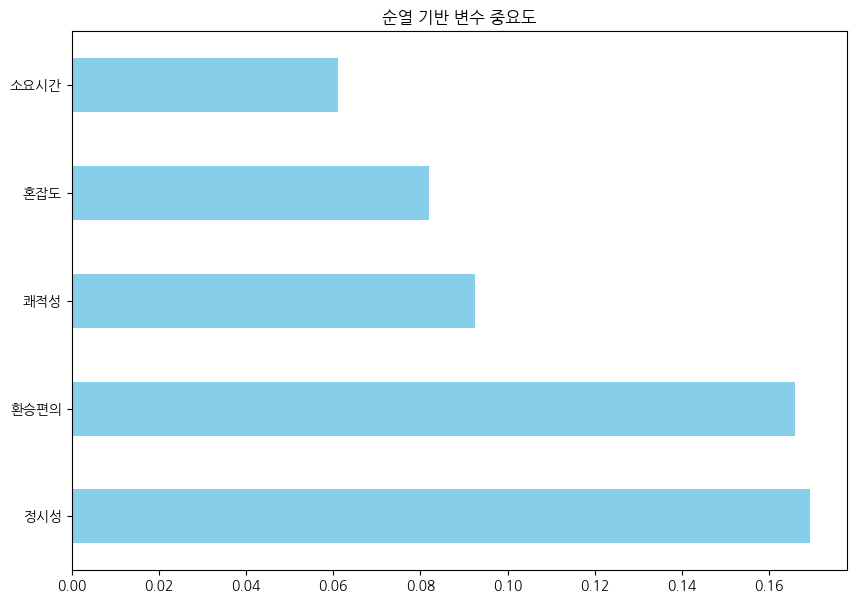


[ '긍정(1)' 클래스에 대한 SHAP 요약 플롯 ]


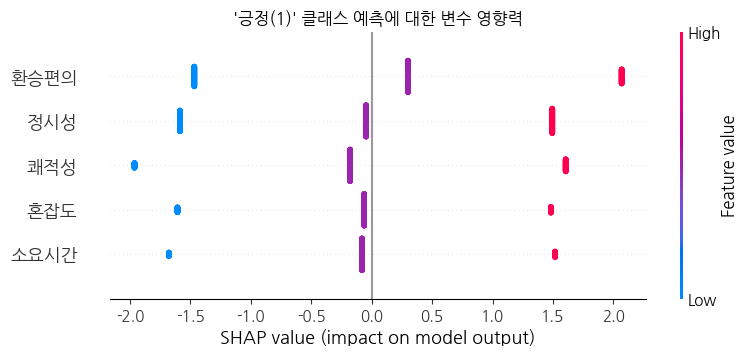


--- 학습 곡선 분석 (Learning Curve) ---


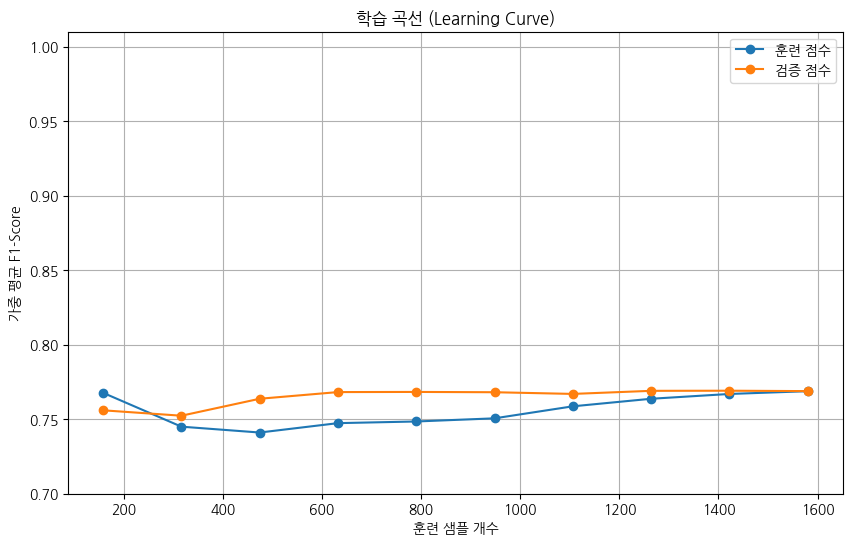


--- 우도비 검정 ---
카이제곱 통계량: 1936.78, 자유도: 10, P-value: 0.0000
>> 결론: 모델은 통계적으로 유의함 (p < 0.05).


In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from scipy import stats

warnings.filterwarnings('ignore') # 경고 메시지 무시

def setup_colab_environment():
    """
    Colab 환경 설정.
    한글 폰트(나눔고딕) 설치.
    """
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    if os.path.exists(font_path): return False # 폰트가 이미 설치되어 있을 때

    try:
        import google.colab # Colab 환경인지 확인
        print(">> 1단계: 환경 설정 시작...")
        os.system('apt-get -qq install fonts-nanum') # 한글 폰트 설치
        os.system('fc-cache -fv') # 폰트 캐시 재구축
        os.system('rm -rf ~/.cache/matplotlib') # matplotlib 캐시 삭제
        os.system('pip install shap > /dev/null') # shap 라이브러리 설치
        plt.rcParams['axes.unicode_minus'] = False
        plt.rcParams['font.family'] = ['NanumGothic', 'DejaVu Sans', 'Arial']
        print("\n************************************************************")
        print(">> 환경 설정 완료. [중요] Colab 메뉴에서 [런타임] > [세션 다시 시작] 후 다시 실행.")
        print("************************************************************")
        return True
    except ImportError:
        print(">> Colab 환경이 아님.")
        return False

def configure_fonts():
    """
    Matplotlib 폰트 설정.
    """
    try: fm._rebuild() # matplotlib 폰트 캐시 강제 재설정
    except: pass
    plt.rc('font', family='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
    plt.rcParams['mathtext.fontset'] = 'stix' # 수학 기호 폰트 설정
    print(">> 폰트 설정이 적용되었습니다. 분석을 시작합니다.")

def load_and_preprocess_data(file_path):
    """
    데이터 로드 및 전처리.

    요인 별 만족 여부 및 종합 만족도 데이터 로드. '종합 만족도' 피처를 -1(부정), 0(중립), 1(긍정)로 변환.
    모델링에 사용할 독립 변수(X-요인)와 종속 변수(y-종합만족도)를 분리해서 반환.

    Returns:
        tuple: (X, y, factor_features) 튜플.
               - X (pd.DataFrame): 모델 훈련에 사용할 독립 변수.
               - y (pd.Series): 예측 대상 종속 변수.
               - factor_features (list): 사용된 독립 변수 이름 리스트.
    """
    print("\n### 1. 데이터 로드 및 전처리 ###")
    try: df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"오류: '{file_path}' 파일을 찾을 수 없음.")
        return None, None, None
    df.columns = df.columns.str.strip() # 컬럼명 공백 제거
    df['종합 만족도'] = pd.to_numeric(df['종합 만족도'], errors='coerce')
    df.dropna(subset=['종합 만족도'], inplace=True)
    df['y_multi'] = np.select([df['종합 만족도'] < 0, df['종합 만족도'] == 0], [-1, 0], default=1)
    factor_features = ['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']
    X = df[factor_features]
    y = df['y_multi']
    print(">> 데이터 처리 완료.")
    return X, y, factor_features

def train_and_evaluate_model(X, y):
    """
    로지스틱 회귀 모델 훈련 및 평가.

    데이터 분할, 결측치 처리, 스케일링, 모델 훈련을 위한 파이프라인 구성.
    GridSearchCV(하이퍼 파라미터 튜닝), 테스트 세트 성능 리포트 출력.

    Args:
        X (pd.DataFrame): 훈련용 독립 변수.
        y (pd.Series): 예측 대상 종속 변수.

    Returns:
        tuple: (best_model, X_test, y_test, X_train) 튜플.
               - best_model (Pipeline): 훈련된 최적 모델.
               - X_test (pd.DataFrame): 평가용 테스트 세트 독립 변수.
               - y_test (pd.Series): 평가용 테스트 세트 종속 변수.
               - X_train (pd.DataFrame): 훈련용 학습 세트 독립 변수.
    """
    print("\n### 2. 모델 훈련 및 성능 평가 ###")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)), # 결측치를 0으로 대체
        ('scaler', StandardScaler()), # 데이터 표준화
        ('clf', LogisticRegression(multi_class='multinomial', max_iter=2000, solver='saga')) # 다중 로지스틱 회귀
    ])
    param_grid = [
        {'clf__penalty': ['l2', 'l1'], 'clf__C': np.logspace(-3, 2, 6), 'clf__class_weight': ['balanced']},
        {'clf__penalty': ['elasticnet'], 'clf__l1_ratio': [0.2, 0.5, 0.8], 'clf__C': np.logspace(-3, 2, 6), 'clf__class_weight': ['balanced'], 'clf__solver': ['saga']}
    ]
    grid = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(5), scoring='f1_weighted', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"\n최적 하이퍼파라미터: {grid.best_params_}\n")
    print("--- 분류 리포트 (테스트 세트) ---")
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    return best_model, X_test, y_test, X_train

def plot_validation_curve(model, X, y, param_name, param_range, title):
    """
    검증 곡선 시각화.
    Args:
        model (Pipeline): 평가할 모델.
        X (pd.DataFrame): 전체 독립 변수.
        y (pd.Series): 전체 종속 변수.
        param_name (str): 검증할 하이퍼파라미터 이름.
        param_range (array-like): 테스트할 하이퍼파라미터 값의 범위.
        title (str): 그래프 제목.
    """
    print(f"\n--- {title} ---")
    train_scores, val_scores = validation_curve(
        estimator=model, X=X, y=y, param_name=param_name, param_range=param_range,
        cv=StratifiedKFold(5), scoring='f1_weighted', n_jobs=-1
    )
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), 'o-', label='훈련 점수')
    plt.plot(param_range, np.mean(val_scores, axis=1), 'o-', label='검증 점수')
    plt.title(f'검증 곡선: {title}'); plt.xlabel(f'하이퍼파라미터: {param_name}'); plt.ylabel('가중 평균 F1-Score')
    plt.xscale('log'); plt.grid(True); plt.legend(loc='best'); plt.show()

def analyze_feature_importance(model, X_test, y_test, X_train):
    """
    변수(Feature) 중요도 분석 및 시각화.

    - 혼동 행렬: 클래스별 모델 예측 성능 분석.
    - 순열 중요도: 변수 무작위화 시 성능 감소를 측정해 중요도 평가.
    - SHAP 요약 플롯: 각 변수가 예측에 미치는 영향력과 방향을 시각화.

    Args:
        model (Pipeline): 분석할 훈련된 모델.
        X_test (pd.DataFrame): 테스트 데이터 독립 변수.
        y_test (pd.Series): 테스트 데이터 종속 변수.
        X_train (pd.DataFrame): SHAP 분석용 훈련 데이터 독립 변수.
    """
    cm = confusion_matrix(y_test, model.predict(X_test), labels=[-1, 0, 1])
    plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['부정', '중립', '긍정'], yticklabels=['부정', '중립', '긍정'])
    plt.title('혼동 행렬 (Confusion Matrix)'); plt.show()

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy')
    perm_importance = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
    print("\n[순열 중요도 결과 (높을수록 중요)]"); print(perm_importance)
    plt.figure(figsize=(10, 7)); perm_importance.plot(kind='barh', color='skyblue')
    plt.title('순열 기반 변수 중요도'); plt.show()

    imputer, scaler, classifier = model.named_steps['imputer'], model.named_steps['scaler'], model.named_steps['clf']
    X_train_processed = pd.DataFrame(scaler.transform(imputer.transform(X_train)), columns=X_train.columns)
    X_test_processed = pd.DataFrame(scaler.transform(imputer.transform(X_test)), columns=X_test.columns)
    explainer = shap.Explainer(classifier, X_train_processed)
    shap_values = explainer(X_test_processed)
    print("\n[ '긍정(1)' 클래스에 대한 SHAP 요약 플롯 ]")
    shap.summary_plot(shap_values.values[:,:,2], X_test_processed, show=False)
    plt.title("'긍정(1)' 클래스 예측에 대한 변수 영향력"); plt.show()

def plot_learning_curve(model, X, y):
    """
    학습 곡선 시각화.

    Args:
        model (Pipeline): 평가할 모델.
        X (pd.DataFrame): 전체 독립 변수.
        y (pd.Series): 전체 종속 변수.
    """
    print("\n--- 학습 곡선 분석 (Learning Curve) ---")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model, X=X, y=y, cv=cv, scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='훈련 점수')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='검증 점수')
    plt.title('학습 곡선 (Learning Curve)'); plt.xlabel('훈련 샘플 개수'); plt.ylabel('가중 평균 F1-Score')
    plt.grid(True); plt.legend(loc='best'); plt.ylim(0.7, 1.01); plt.show()

def validate_model_significance(model, X, y):
    """
    우도비 검정(Likelihood Ratio Test)으로 모델 유의성 검증.

    전체 변수를 사용한 모델이 변수가 없는 모델(귀무 모델)보다
    통계적으로 유의미한지 판별.

    Args:
        model (Pipeline): 평가할 모델.
        X (pd.DataFrame): 전체 독립 변수.
        y (pd.Series): 전체 종속 변수.
    """
    print("\n--- 우도비 검정 ---")
    imputer, scaler = model.named_steps['imputer'], model.named_steps['scaler']
    X_processed = pd.DataFrame(scaler.transform(imputer.transform(X)), columns=X.columns)
    y_recoded = y.replace({-1: 0, 0: 1, 1: 2}) # statsmodels를 위해 레이블 재코딩 (0, 1, 2)
    X_const = sm.add_constant(X_processed)

    full_model = sm.MNLogit(y_recoded, X_const).fit(disp=0) # 전체 모델
    null_model = sm.MNLogit(y_recoded, X_const[['const']]).fit(disp=0) # 귀무 모델

    lr_statistic = 2 * (full_model.llf - null_model.llf)
    degrees_of_freedom = full_model.df_model
    p_value = stats.chi2.sf(lr_statistic, degrees_of_freedom)

    print(f"카이제곱 통계량: {lr_statistic:.2f}, 자유도: {int(degrees_of_freedom)}, P-value: {p_value:.4f}")
    if p_value < 0.05: print(">> 결론: 모델은 통계적으로 유의함 (p < 0.05).")
    else: print(">> 결론: 모델이 통계적으로 유의하지 않음 (p >= 0.05).")

# ==========================================================================
# 메인 실행 로직: 전체 분석 파이프라인 실행
# ==========================================================================
if not setup_colab_environment():
    configure_fonts()
    FILE_PATH = '/content/drive/MyDrive/sentiment_sign_agreement_merged.xlsx'
    X, y, factor_features = load_and_preprocess_data(FILE_PATH)

    if X is not None and y is not None:
        best_model, X_test, y_test, X_train = train_and_evaluate_model(X, y)

        print("\n### 3. 모델 진단 및 요인 분석 ###")

        # 최적 모델의 복잡도 진단을 위한 검증 곡선 시각화
        best_penalty = best_model.named_steps['clf'].penalty
        vc_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                multi_class='multinomial', max_iter=2000, solver='saga',
                penalty=best_penalty, class_weight='balanced',
                l1_ratio=best_model.named_steps['clf'].l1_ratio if best_penalty == 'elasticnet' else None
            ))
        ])
        plot_validation_curve(vc_pipe, X, y, 'clf__C', np.logspace(-4, 4, 10),
                              title=f"규제 강도(C)에 따른 모델 성능 변화 (Penalty: {best_penalty})")

        # 변수(요인)의 영향력을 다각도로 분석
        analyze_feature_importance(best_model, X_test, y_test, X_train)

        # 데이터 양에 따른 모델 성능 변화 확인
        plot_learning_curve(best_model, X, y)

        # 개발된 모델의 통계적 유의성 최종 검증
        validate_model_significance(best_model, X, y)